# Initialization

In [ ]:
!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2023-02-14 06:01:01--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 13.33.21.90, 13.33.21.119, 13.33.21.115, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|13.33.21.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G   150MB/s    in 32s     

2023-02-14 06:01:33 (125 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
from PIL import Image
from pyquaternion import Quaternion
from typing import Tuple, List, Iterable
from nuscenes.nuscenes import NuScenes
from nuscenes.nuscenes import NuScenesExplorer
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)
ne = NuScenesExplorer(nusc)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.074 seconds.
Reverse indexing ...
Done reverse indexing in 0.3 seconds.


In [ ]:
def map_pointcloud_to_image(
                            pointsensor_token: str,
                            camera_token: str,
                            min_dist: float = 1.0,
                            render_intensity: bool = False,
                            show_lidarseg: bool = False,
                            filter_lidarseg_labels: List = None,
                            lidarseg_preds_bin_path: str = None,
                            show_panoptic: bool = False) -> Tuple:


    cam = nusc.get('sample_data', camera_token)
    pointsensor = nusc.get('sample_data', pointsensor_token)
    pcl_path = osp.join(nusc.dataroot, pointsensor['filename'])
    if pointsensor['sensor_modality'] == 'lidar':
        if show_lidarseg or show_panoptic:
            gt_from = 'lidarseg' if show_lidarseg else 'panoptic'
            assert hasattr(nusc, gt_from), f'Error: nuScenes-{gt_from} not installed!'

            # Ensure that lidar pointcloud is from a keyframe.
            assert pointsensor['is_key_frame'], \
                'Error: Only pointclouds which are keyframes have lidar segmentation labels. Rendering aborted.'

            assert not render_intensity, 'Error: Invalid options selected. You can only select either ' \
                                          'render_intensity or show_lidarseg, not both.'

        pc = LidarPointCloud.from_file(pcl_path)
    else:
        pc = RadarPointCloud.from_file(pcl_path)
    im = Image.open(osp.join(nusc.dataroot, cam['filename']))

    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record1 = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record1['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record1['translation']))

    # Second step: transform from ego to the global frame.
    poserecord1 = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    pc.rotate(Quaternion(poserecord1['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord1['translation']))

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    poserecord2 = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord2['translation']))
    pc.rotate(Quaternion(poserecord2['rotation']).rotation_matrix.T)

    # Fourth step: transform from ego into the camera.
    cs_record2 = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record2['translation']))
    pc.rotate(Quaternion(cs_record2['rotation']).rotation_matrix.T)

    # Fifth step: actually take a "picture" of the point cloud.
    # Grab the depths (camera frame z axis points away from the camera).
    depths = pc.points[2, :]

    return cs_record1, poserecord1, poserecord2, cs_record2

# Question 3

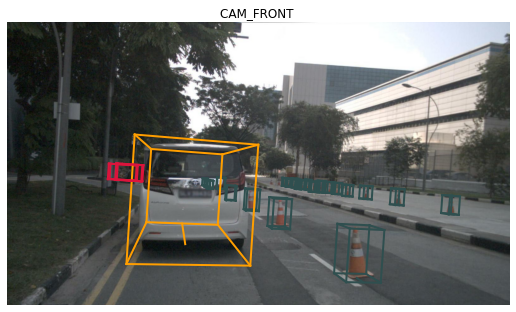

In [ ]:
my_sample = nusc.sample[25]

# Visualize the camera data
nusc.render_sample_data(my_sample['data']['CAM_FRONT'], nsweeps=5, underlay_map=True)

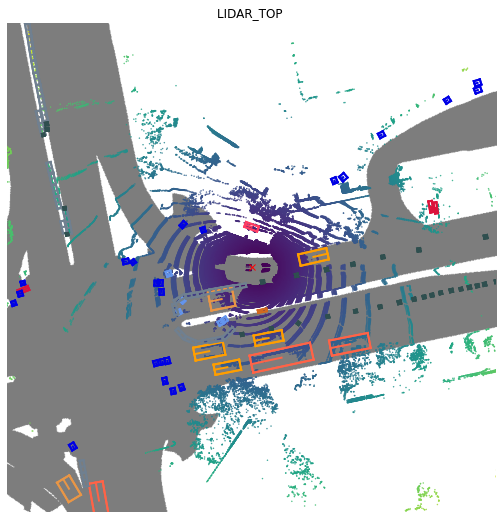

In [ ]:
# Visualize the lidar data
nusc.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=5, underlay_map=True)

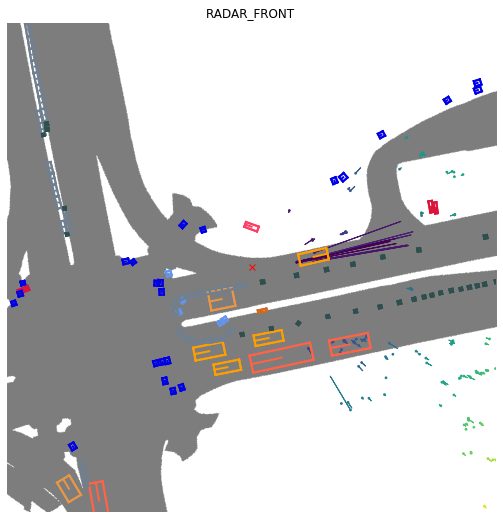

In [ ]:
# Visualize the radar data
nusc.render_sample_data(my_sample['data']['RADAR_FRONT'], nsweeps=5, underlay_map=True)

# Question 5

## 5.1

In [84]:
# Print calibration info between Radar and camera sensor
map_pointcloud_to_image(my_sample['data']['RADAR_FRONT'], my_sample['data']['CAM_FRONT'])

({'token': 'f4d2a6c281f34a7eb8bb033d82321f79',
  'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
  'translation': [3.412, 0.0, 0.5],
  'rotation': [0.9999984769132877, 0.0, 0.0, 0.0017453283658983088],
  'camera_intrinsic': []},
 {'token': '9fd2ddc8a358432ab440c425ed9c039d',
  'timestamp': 1532402940198168,
  'rotation': [0.9544713657713595,
   -0.030776724641293652,
   0.010063913985182244,
   -0.2965399176809236],
  'translation': [405.5942906309436, 1111.558578106388, 0.0]},
 {'token': '4bc3a28622964e9f9ab28a68614189f1',
  'timestamp': 1532402940162460,
  'rotation': [0.9537995082084341,
   -0.03107903461608443,
   0.010278165284580327,
   -0.2986552378028284],
  'translation': [405.49180331283605, 1111.6306715859482, 0.0]},
 {'token': '1d31c729b073425e8e0202c5c6e66ee1',
  'sensor_token': '725903f5b62f56118f4094b46a4470d8',
  'translation': [1.70079118954, 0.0159456324149, 1.51095763913],
  'rotation': [0.4998015430569128,
   -0.5030316162024876,
   0.4997798114386805,
   -0.497

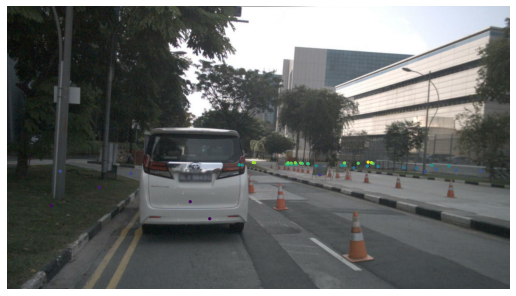

In [ ]:
# Visualize Radar data projection on image
ne.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT', camera_channel='CAM_FRONT')

## 5.2

In [86]:
# Print calibration info between Lidar and camera sensor
map_pointcloud_to_image(my_sample['data']['LIDAR_TOP'], my_sample['data']['CAM_FRONT'])

({'token': 'a183049901c24361a6b0b11b8013137c',
  'sensor_token': 'dc8b396651c05aedbb9cdaae573bb567',
  'translation': [0.943713, 0.0, 1.84023],
  'rotation': [0.7077955119163518,
   -0.006492242056004365,
   0.010646214713995808,
   -0.7063073142877817],
  'camera_intrinsic': []},
 {'token': 'ba77cd8dab87477ab3cbcb044c3a2396',
  'timestamp': 1532402940197958,
  'rotation': [0.9544754702328649,
   -0.030778857588297338,
   0.010064532228615017,
   -0.2965264639797418],
  'translation': [405.59378952934526, 1111.5587954693658, 0.0]},
 {'token': '4bc3a28622964e9f9ab28a68614189f1',
  'timestamp': 1532402940162460,
  'rotation': [0.9537995082084341,
   -0.03107903461608443,
   0.010278165284580327,
   -0.2986552378028284],
  'translation': [405.49180331283605, 1111.6306715859482, 0.0]},
 {'token': '1d31c729b073425e8e0202c5c6e66ee1',
  'sensor_token': '725903f5b62f56118f4094b46a4470d8',
  'translation': [1.70079118954, 0.0159456324149, 1.51095763913],
  'rotation': [0.4998015430569128,
   -0

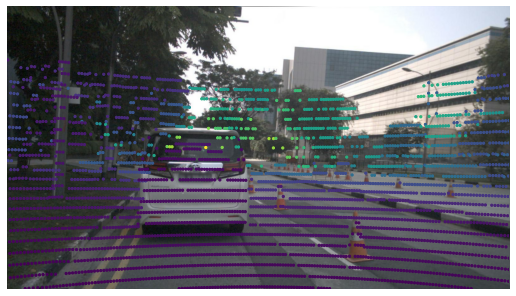

In [ ]:
# Visualize Lidar data projection on image
ne.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP', camera_channel='CAM_FRONT')